<a href="https://colab.research.google.com/github/RatishkumarS/Predictive_Maintanence/blob/main/Predictive_Maintanence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

**Data Preprocessing:** Power of each PV inverter is fed as a excel file and the data is cleaned by removing any duplicates or null readings

In [ ]:
# Load the data again, skipping the first row to use the second row as header
data = pd.read_excel("./In_Power.xlsx", header=1)

with pd.ExcelFile("./In_Power.xlsx") as xls:
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=None)
        start_row = df[df.apply(lambda row: row.astype(str).str.contains('Date').any(), axis=1)].index[0]
        break

# Rename columns for clarity
data.columns = ['Date', 'Time', 'PV1 DC Power', 'PV2 DC Power', 'PV3 DC Power', 'PV4 DC Power', 'PV5 DC Power', 'PV6 DC Power', 'PV7 DC Power', 'PV8 DC Power', 'PV10 DC Power']

# Drop the 'Raw Timestamp' and 'PV10 DC Power' columns since they are not needed
data = data.drop([ 'PV10 DC Power'], axis=1)

data['Date'] = data['Date'].astype(str)
data['Time'] = data['Time'].astype(str)

# Combine 'Date' and 'Time' into a single datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], infer_datetime_format=True, errors='coerce')

# Drop the now redundant 'Date' and 'Time' columns
data = data.drop(['Date', 'Time'], axis=1)

# Reorder columns to place 'Datetime' at the start
data = data[['Datetime', 'PV1 DC Power', 'PV2 DC Power', 'PV3 DC Power', 'PV4 DC Power', 'PV5 DC Power', 'PV6 DC Power', 'PV7 DC Power', 'PV8 DC Power']]

# Replace NaN values with 0
data = data.fillna(0)

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Check for duplicates
duplicates = data.duplicated().sum()
print("Duplicate Rows:\n", duplicates)

# Remove duplicates
data = data.drop_duplicates()

# Ensure correct data types
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')
for col in data.columns[1:]:
    data[col] = data[col].astype(float)

# Display summary of cleaned data
print(data.info())
print(data.head())


Missing Values:
 Datetime        0
PV1 DC Power    0
PV2 DC Power    0
PV3 DC Power    0
PV4 DC Power    0
PV5 DC Power    0
PV6 DC Power    0
PV7 DC Power    0
PV8 DC Power    0
dtype: int64
Duplicate Rows:
 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15704 entries, 0 to 15703
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      15704 non-null  datetime64[ns]
 1   PV1 DC Power  15704 non-null  float64       
 2   PV2 DC Power  15704 non-null  float64       
 3   PV3 DC Power  15704 non-null  float64       
 4   PV4 DC Power  15704 non-null  float64       
 5   PV5 DC Power  15704 non-null  float64       
 6   PV6 DC Power  15704 non-null  float64       
 7   PV7 DC Power  15704 non-null  float64       
 8   PV8 DC Power  15704 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 1.1 MB
None
                 Datetime  PV1 DC Power  PV2 DC Power  PV3 DC Power

<ipython-input-11-d60e509a501a>:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], infer_datetime_format=True, errors='coerce')


**Data Visualization:** Visualizing PV inverters power falls into what ranges and seeing the corelation between them using a matrix

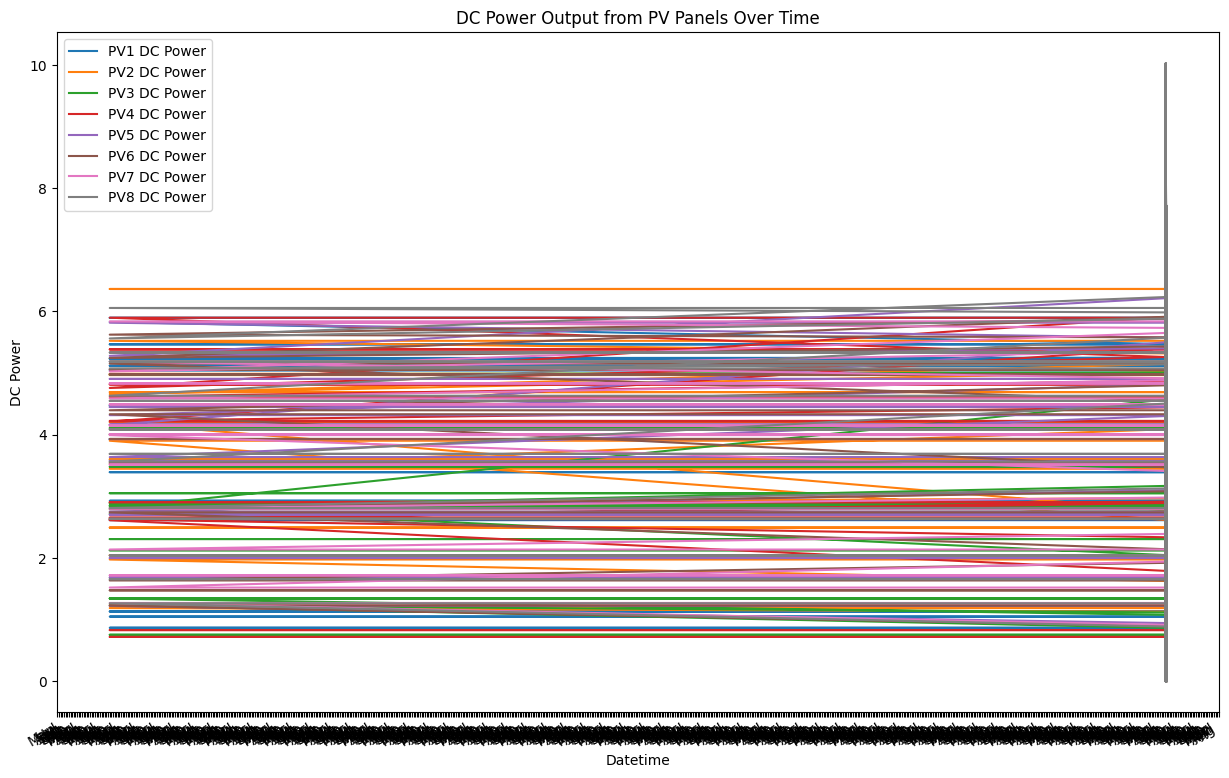

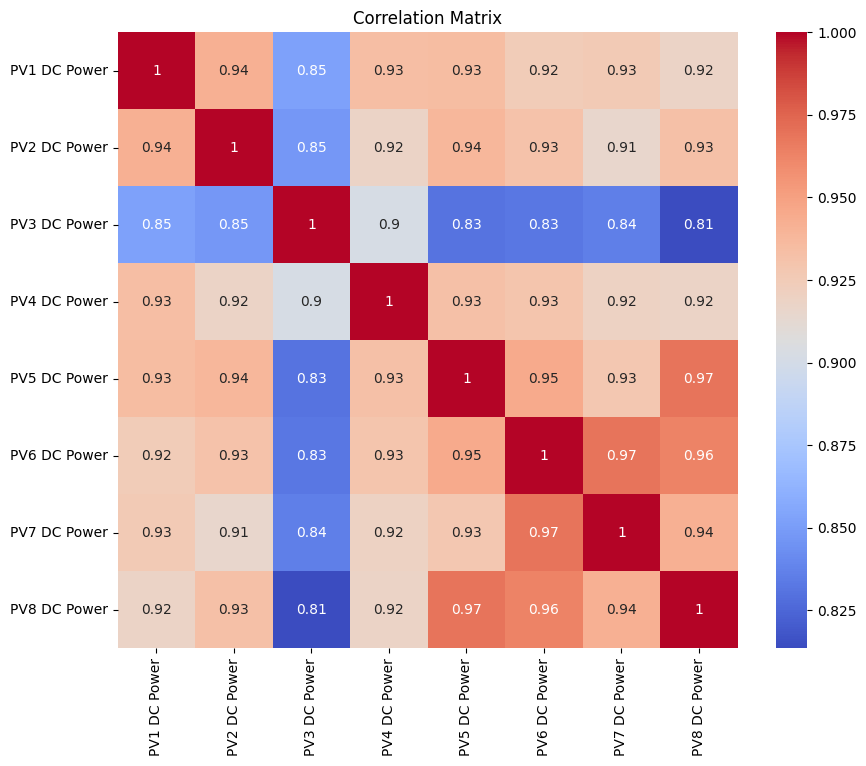

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'Datetime' column is parsed correctly
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce')

# Drop rows where 'Datetime' could not be parsed
data = data.dropna(subset=['Datetime'])

# Set 'Datetime' as the index
data = data.set_index('Datetime')

# Plotting DC Power for each PV panel
plt.figure(figsize=(15, 10))
for col in data.columns:
    plt.plot(data.index, data[col], label=col)

# Formatting the x-axis to show only months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gcf().autofmt_xdate()  # Rotate the x-axis labels for better readability

plt.xlabel('Datetime')
plt.ylabel('DC Power')
plt.title('DC Power Output from PV Panels Over Time')
plt.legend(loc='best')
plt.show()

# Correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


**Feature Engineering:** Adding extra features useful for performing predictive maintanence. Doing rolling mean to smooth out the disturbances throughout the dataset. Doing difference between inverters powers to make use of them as features for anamoly prediction

In [ ]:
# Creating rolling average features
for col in data.columns:
    data[col + '_rolling_mean'] = data[col].rolling(window=3).mean()

# Creating difference features
for col in data.columns:
    data[col + '_diff'] = data[col].diff()

# Drop NaN values created by rolling and diff operations
data = data.dropna()

data.head()


,PV1 DC Power,PV2 DC Power,PV3 DC Power,PV4 DC Power,PV5 DC Power,PV6 DC Power,PV7 DC Power,PV8 DC Power,PV1 DC Power_rolling_mean,PV2 DC Power_rolling_mean,...,PV7 DC Power_diff,PV8 DC Power_diff,PV1 DC Power_rolling_mean_diff,PV2 DC Power_rolling_mean_diff,PV3 DC Power_rolling_mean_diff,PV4 DC Power_rolling_mean_diff,PV5 DC Power_rolling_mean_diff,PV6 DC Power_rolling_mean_diff,PV7 DC Power_rolling_mean_diff,PV8 DC Power_rolling_mean_diff
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-15 14:55:18.537,9.293,8.808,6.328,7.946,8.991,8.129,7.984,9.625,9.293000,8.808,...,0.0,0.000,0.000000,0.000,-0.232333,-0.385,0.000,0.0,-0.558333,0.000000
2023-11-15 14:55:18.744,9.007,8.808,6.328,7.946,8.991,8.129,7.984,9.625,9.197667,8.808,...,0.0,0.000,-0.095333,0.000,-0.232333,0.000,0.000,0.0,-0.558333,0.000000
2023-11-15 14:55:56.834,9.007,8.808,6.328,7.946,9.426,8.129,7.984,9.625,9.102333,8.808,...,0.0,0.000,-0.095333,0.000,-0.232333,0.000,0.145,0.0,0.000000,0.000000
2023-11-15 14:55:57.041,9.007,8.808,6.328,7.946,9.426,8.129,7.984,10.029,9.007000,8.808,...,0.0,0.404,-0.095333,0.000,0.000000,0.000,0.145,0.0,0.000000,0.134667
2023-11-15 14:55:57.247,9.007,9.063,6.328,7.946,9.426,8.129,7.984,10.029,9.007000,8.893,...,0.0,0.000,0.000000,0.085,0.000000,0.000,0.145,0.0,0.000000,0.134667


Training a Random Forest classifier machine learning model to train the novembers months power data.This we are using as a reference to predict weather we need to do maintanence.

In [ ]:
# Creating labels for maintenance needs (e.g., 1 if power output drops significantly, 0 otherwise)
data['Maintenance_Needed'] = (data['PV1 DC Power_diff'] < -0.5).astype(int)

# Features and labels
features = data.drop(['Maintenance_Needed'], axis=1)
labels = data['Maintenance_Needed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


<ipython-input-14-9500946e1290>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Maintenance_Needed'] = (data['PV1 DC Power_diff'] < -0.5).astype(int)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3131
           1       1.00      0.90      0.95        10

    accuracy                           1.00      3141
   macro avg       1.00      0.95      0.97      3141
weighted avg       1.00      1.00      1.00      3141



Here, we are doing the predictions with the same november months data to see if it detecting 0 maintanence. That is the zeroes you will be able to see in the form of an array in the end.

In [ ]:
# Assuming new_data is a DataFrame with the same structure as the training data
new_data = data.copy()# Load or prepare your new data


# Ensure the same feature engineering steps are applied
# new_data['Datetime'] =  pd.to_datetime(data['Datetime'], errors='coerce')
# new_data.set_index('Datetime', inplace=True)


for col in new_data.columns:
    new_data[col + '_rolling_mean'] = new_data[col].rolling(window=3).mean()
    new_data[col + '_diff'] = new_data[col].diff()
new_data = new_data.dropna()
new_data.head()

features_to_use = [col for col in new_data.columns if col in X_train.columns]
predictions = model.predict(new_data[features_to_use])
print(predictions)
# # Make predictions
# predictions = model.predict(new_data)
# print(predictions)


[0 0 0 ... 0 0 0]


We may parse the above array along with PV inverters number as JSON to suggest if a panels in the inverter requires inspection check.

In [ ]:
print("Training data label distribution:")
print(labels.value_counts())

Training data label distribution:
Maintenance_Needed
0    15670
1       31
Name: count, dtype: int64
